<a href="https://colab.research.google.com/github/majidsadrii/persian_vehicle_license/blob/main/plates.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [61]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [62]:
import os
project_dir =  '/content/drive/MyDrive/car_plate' 
images_n_vids_path = "/content/dataset/Vehicle Plates/Vehicle Plates"
savepath = "/content/drive" 
weights = '/content/drive/MyDrive/car_plate/yolov7/runs/train/exp6/weights/best.pt'

image_size = 640

os.chdir(project_dir)
!pip install -r requirements.txt
from colorama import Fore

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


# persian font 

In [63]:
if  not os.path.isfile('/content/drive/MyDrive/car_plate/persian_font/Vazirmatn-Black.ttf'):
  print(Fore.CYAN,'donwloading appropriate persian font')
  os.chdir('/content')
  !git clone https://github.com/rastikerdar/vazirmatn.git
  %cp /content/vazirmatn/fonts/ttf/* /content/drive/MyDrive/car_plate/persian_font
else:
    print(Fore.CYAN,'you have already vaziri font')

 you have already vaziri font


In [64]:
yolo_path = os.path.join(project_dir, "yolov7")
os.chdir(yolo_path)
import shutil
import torch
from pathlib import Path
from typing import Union
import torch
import cv2 as cv
import numpy as np
from deep_sort_realtime.deepsort_tracker import DeepSort
from models.experimental import attempt_load
from utils.general import check_img_size
from utils.torch_utils import select_device, TracedModel
from utils.datasets import letterbox
from utils.general import non_max_suppression, scale_coords
# from utils.plots import plot_one_box, plot_one_box_PIL
from copy import deepcopy
import easyocr
from google.colab.patches import cv2_imshow

In [65]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
trace = False

cpu


In [66]:
half = device.type != 'cpu'  # half precision only supported on CUDA

# Load model
model = attempt_load(weights, map_location=device)  # load FP32 model
stride = int(model.stride.max())  # model stride
imgsz = check_img_size(image_size, s=stride)  # check img_size

if trace:
    model = TracedModel(model, device, image_size)

if half:
    model.half()  # to FP16
    
if device.type != 'cpu':
    model(torch.zeros(1, 3, imgsz, imgsz).to(device).type_as(next(model.parameters())))  # run once


# Load OCR
reader = easyocr.Reader(['fa'])

Fusing layers... 
RepConv.fuse_repvgg_block
RepConv.fuse_repvgg_block
RepConv.fuse_repvgg_block


IDetect.fuse


In [67]:
from PIL import Image, ImageDraw, ImageFont
def plot_one_box_PIL(box, img, color=None, label=None, line_thickness=None,font_path=None):
    img = Image.fromarray(img)
    draw = ImageDraw.Draw(img)
    line_thickness = line_thickness or max(int(min(img.size) / 200), 2)
    draw.rectangle(box, width=line_thickness, outline=tuple(color))  # plot
    if label:
        fontsize = max(round(max(img.size) / 40), 12)
        font = ImageFont.truetype(font_path, fontsize)
        txt_width, txt_height = font.getsize(label)
        draw.rectangle([box[0], box[1] - txt_height + 4, box[0] + txt_width, box[1]], fill=tuple(color))
        draw.text((box[0], box[1] - txt_height + 1), label, fill=(255, 255, 255), font=font)
    return np.asarray(img)


In [68]:
from math import sqrt, atan, degrees
   
def find_longest_line(plate_img_gr):
    kernel_size = 3
    blur_gray = cv.GaussianBlur(plate_img_gr, (kernel_size, kernel_size), 0)

    low_threshold = 150
    high_threshold = 200

    edges = cv.Canny(blur_gray, low_threshold, high_threshold)

    rho = 1  # distance resolution in pixels of the Hough grid
    theta = np.pi / 180  # angular resolution in radians of the Hough grid
    threshold = 15  # minimum number of votes (intersections in Hough grid cell)
    min_line_length = 50  # minimum number of pixels making up a line
    max_line_gap = 5  # maximum gap in pixels between connectable line segments
    line_image = np.copy(plate_img_gr) * 0  # creating a blank to draw lines on

    # Run Hough on edge detected image
    # Output "lines" is an array containing endpoints of detected line segments
    lines = cv.HoughLinesP(edges, rho, theta, threshold, np.array([]),
                        min_line_length, max_line_gap)

    lls = []
    if  lines is not None:
      for indx, line in enumerate(lines):
          for x1,y1,x2,y2 in line:
              cv.line(line_image,(x1,y1),(x2,y2),(255,0,0),5)
              line_length = sqrt((x2-x1)**2 + (y2-y1)**2)
              lls.append((indx,line_length))
      lls.sort(key = lambda x: x[1])
      linessorted = []
      for (indx,ll) in lls:
          linessorted.append(lines[indx])
      return linessorted
    else:
      return False

def find_line_angle(line):
    x1,y1,x2,y2 = line[0]
    angle = degrees(atan(((y2-y1)/(x2-x1))))
    return angle

def rotate_image(plate_img_gr, angle):
    (h, w) = plate_img_gr.shape
    (cX, cY) = (w // 2, h // 2)
    M = cv.getRotationMatrix2D((cX, cY), angle, 1.0)
    rotated = cv.warpAffine(plate_img_gr, M, (w, h))
    (h_r, w_r) = plate_img_gr.shape

    if h_r< (h/15) or w_r< (w/15):
      print(Fore.YELLOW,'Not a good rotation, we use the main image')
      return plate_img_gr
    else:
        return rotated

def adjust_cropping(rotated_img):
    h,w = rotated_img.shape
    targ_h = int(w/4)
    crop_h = int((h - targ_h)/2)
    cropped_rotated_img = rotated_img[crop_h:h-crop_h,:]
    return cropped_rotated_img

def make_plate_horizantal(plate_img,save_rotated =False,save_path=None,save_name=None):
  plate_img_gr = cv.cvtColor(plate_img, cv.COLOR_BGR2GRAY)
  linessorted = find_longest_line(plate_img_gr)
  if linessorted:

    rot_angle = find_line_angle(linessorted[-1])
    rotated_img = rotate_image(plate_img_gr, rot_angle)
    cropped_rotated_img = adjust_cropping(rotated_img)
    if save_rotated:
      cv.imwrite(os.path.join(save_path, 'plate_{}.jpg'.format(save_name)), plate_img_gr)
      cv.imwrite(os.path.join(save_path, 'plate_{}_rotated.jpg'.format(save_name)), cropped_rotated_img)
    return(cropped_rotated_img,rot_angle)

  else:
    print(Fore.RED,'Image has not been rotated',Fore.BLACK)
    return None ,None
      

  

In [69]:
def detect_plate(source_image,img_size = 640):
  
    stride = 32
    img = letterbox(source_image, img_size, stride=stride)[0]

    # Convert
    img = img[:, :, ::-1].transpose(2, 0, 1)  # BGR to RGB, to 3x416x416
    img = np.ascontiguousarray(img)
    img = torch.from_numpy(img).to(device)
    img = img.half() if half else img.float()  # uint8 to fp16/32
    img /= 255.0  # 0 - 255 to 0.0 - 1.0
    if img.ndimension() == 3:
        img = img.unsqueeze(0)
        
    with torch.no_grad():
        # Inference
        pred = model(img, augment=True)[0]

    # Apply NMS
    pred = non_max_suppression(pred, 0.25, 0.45, classes=0, agnostic=True)

    plate_detections = []
    det_confidences = []
    
    # Process detections
    for i, det in enumerate(pred):  # detections per image
        if len(det):
            # Rescale boxes from img_size to im0 size
            det[:, :4] = scale_coords(img.shape[2:], det[:, :4], source_image.shape).round()

            # Return results
            for *xyxy, conf, cls in reversed(det):
                coords = [int(position) for position in (torch.tensor(xyxy).view(1, 4)).tolist()[0]]
                plate_detections.append(coords)
                det_confidences.append(conf.item())

    return plate_detections, det_confidences



    return True




def ocr_plate(plate_region):
    # Image pre-processing for more accurate OCR
    # cv.imwrite(os.path.join(savepath, "plate_img.png"), plate_region)
    rescaled = cv.resize(plate_region, None, fx=1.2, fy=1.2, interpolation=cv.INTER_CUBIC)
    if  len( rescaled .shape) > 2:
         grayscale = cv.cvtColor(rescaled, cv.COLOR_BGR2GRAY)
    else:
      grayscale =rescaled
    
          
    # OCR the preprocessed image
    grayscale_blur = cv.medianBlur(grayscale, 1)
    ret, thresh1 = cv.threshold(grayscale_blur, 120, 255, cv.THRESH_BINARY + cv.THRESH_OTSU) 
    # cv.imwrite(os.path.join(savepath, "grayscale_blur.png"), grayscale_blur)
    plate_text_easyocr = reader.readtext(grayscale_blur)
    

    ###################
    # we should not  let other texts to be selected instead of car plate number
    pr = []
    if plate_text_easyocr:
       for i in range(len(plate_text_easyocr)):
                pr.append((plate_text_easyocr[i][0],plate_text_easyocr[i][1],plate_text_easyocr[i][2]))
      # sorting found text by confidence score
       pr.sort(key=lambda x:x[2])
       pr.reverse()
       (bbox, text_easyocr, ocr_confidence) = pr[0]
       print("plate_text Easyocr ", text_easyocr)
    ##################
    else:
        text_easyocr = "_"
        ocr_confidence = 0
    #if ocr_confidence == 'nan':
    
    return text_easyocr, ocr_confidence


def crop(image, coord):
    cropped_image = image[int(coord[1]):int(coord[3]), int(coord[0]):int(coord[2])]
    return cropped_image
def get_plates_from_image(input,save_dir,Save_Name=None,font_location=None):
    if input is None:
        return None
    plate_detections, det_confidences = detect_plate(input)
    plate_texts = []
    ocr_confidences = []
    detected_image = deepcopy(input)
    for coords in plate_detections:
        plate_region = crop(input, coords)
        plate_region_rotated,rot_ang = make_plate_horizantal(plate_region,save_rotated =True,save_path=save_dir,save_name=Save_Name)
        if plate_region_rotated is not None:
          plate_text, ocr_confidence = ocr_plate(plate_region_rotated)
        else:
          plate_text, ocr_confidence = ocr_plate(plate_region)
        plate_texts.append(plate_text)
        ocr_confidences.append(ocr_confidence)
        detected_image = plot_one_box_PIL(coords, detected_image, label=plate_text, color=[0, 150, 255], line_thickness=2,font_path=font_location)
        cv.imwrite(os.path.join(save_dir, 'detected_{}.jpg'.format(Save_Name)),detected_image)
    return detected_image



In [70]:
data_dir = '/content/drive/MyDrive/car_plate/samples'
save_dir = '/content'
persian_font ='/content/drive/MyDrive/car_plate/persian_font/Vazirmatn-Regular.ttf'
ALL_img = os.listdir( data_dir)
images_to_process = []
images_names = []
for i in range(len(ALL_img)):
  tem = ALL_img[i].split('.')
  
  if tem[-1] == 'jpg' or tem[-1] =='png':
    images_names.append(tem[0].split('/')[-1])
    images_to_process.append(data_dir +'/'+ALL_img[i])
if len(images_to_process)  ==0:
  print(Fore.RED,'there is no jpg or png image')

for index in range(len(images_to_process )):
  input_img = images_to_process[index]
  plate_image = cv.imread(input_img)
  result = get_plates_from_image(plate_image,save_dir= save_dir ,Save_Name = images_names[index],font_location=persian_font )


plate_text Easyocr  ٢٧ ٩٥٤ ٤٦
plate_text Easyocr  ٢٧ ١٩١ ق٣٨


# visualization

In [118]:

from matplotlib import pyplot as plt
%matplotlib inline
import glob
def vis_data_set(data_dir,num_to_vis):
  detected = glob.glob(data_dir+'/detected*.jpg')
  if (num_to_vis)>len(detected):
    raise Exception("Sorry, there are not {} detected images in your directory".format(num_to_vis))

  fig, axs = plt.subplots(1,num_to_vis,figsize=(num_to_vis*8,8))
  plt.tight_layout()
  for c in range(num_to_vis): 
   
    img_pth = os.path.join(data_dir, detected[c] )  
     
    img = cv.imread( img_pth)  
    img =cv.cvtColor(img, cv.COLOR_BGR2RGB)   
    
    plt.subplot(1,num_to_vis, c+1)              
    plt.imshow(img, cmap="gray",interpolation='none')          
    plt.savefig(data_dir+'/result.jpg')


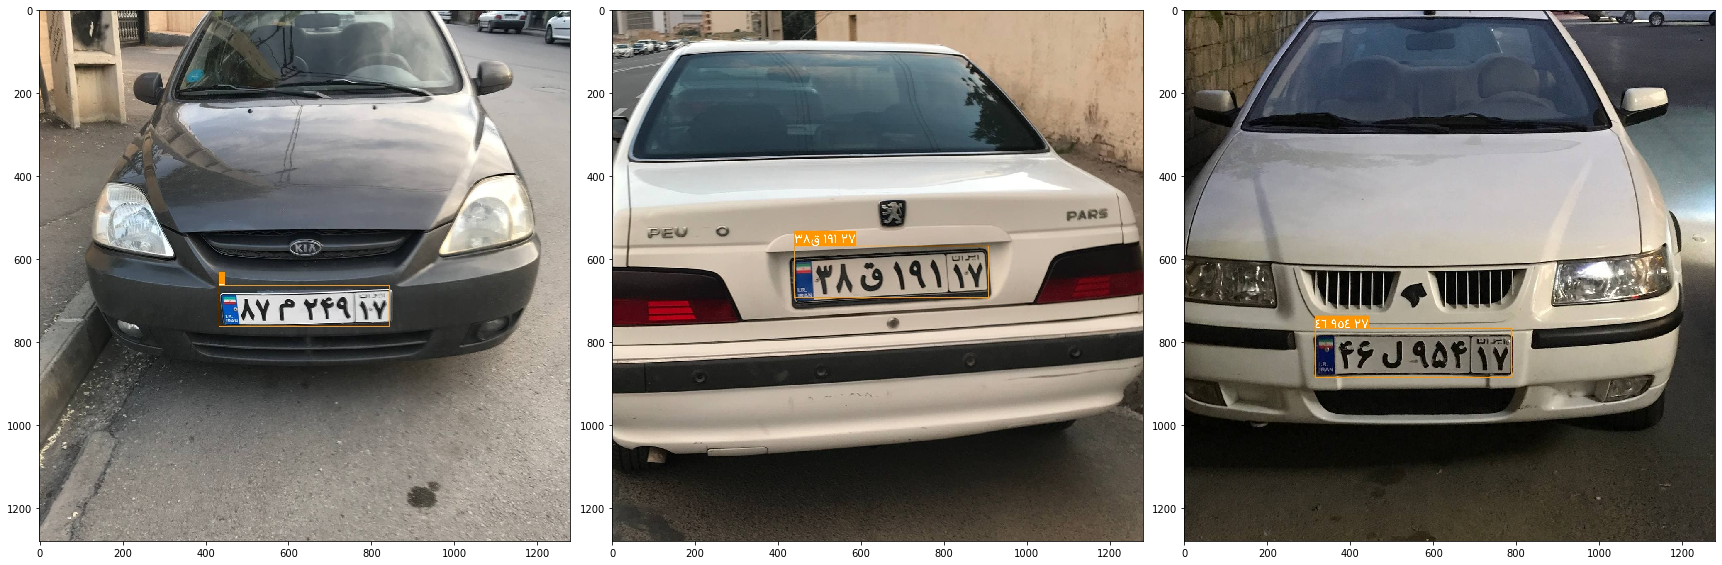

In [119]:
vis_data_set('/content',3)